# TESS

In [1]:
import numpy as np
import starry
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import matplotlib.pyplot as plt
import theano.tensor as tt

starry.config.lazy = True
starry.config.quiet = True

In [2]:
# importing the data into arrays
# first column of the data file is phase data
TessPhaseHalf = np.loadtxt("GD356allTess.dat", usecols=(0))
TessPhase = np.concatenate((TessPhaseHalf, TessPhaseHalf+1))
# second column of the data file is flux data
TessFluxHalf = np.loadtxt("GD356allTess.dat", usecols=(1))
TessFlux = np.concatenate((TessFluxHalf+1, TessFluxHalf+1))
# third column of the data file is flux error
TessErrorHalf = np.loadtxt("GD356allTess.dat", usecols=(2))
TessError = np.concatenate((TessErrorHalf, TessErrorHalf))

In [3]:
def mean_data(Phase, Flux, Error, bins):

    Phase_split = np.array_split(Phase, bins)
    Flux_split = np.array_split(Flux, bins)
    Error_split = np.array_split(Error, bins)

    meanPhase = [] * bins
    meanFlux = [] * bins
    meanError = [] * bins

    for i in range(bins):

        meanPhase_i = np.mean(Phase_split[i])
        meanFlux_i = np.sum(Flux_split[i] / (Error_split[i]**2))/ np.sum(1/(Error_split[i]**2))

        meanError_i = np.sqrt(1/np.sum(1/(Error_split[i]**2)))

        meanPhase.append(meanPhase_i)
        meanFlux.append(meanFlux_i)
        meanError.append(meanError_i)
        
    return meanPhase, meanFlux, meanError

In [4]:
meanPhase, meanFlux, meanError = mean_data(TessPhase, TessFlux, TessError, 200)

TESS_flux = meanFlux
TESS_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

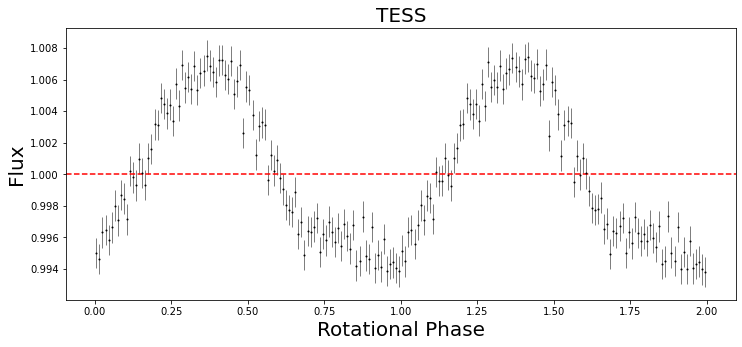

In [5]:
plt.figure(figsize=(12, 5))

plt.title('TESS', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, TESS_flux, yerr=TESS_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [7]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.04)
    radius = 45
    lat = pm.Uniform("lat", lower=0.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=TESS_flux_err, observed=TESS_flux)

In [8]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, contrast]


message: Desired error not necessarily achieved due to precision loss.
logp: -930.6282167377726 -> 1029.133633838719


In [9]:
keys = ["contrast", "lat", "lon", "inc"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.13214
lat          72.95156
lon          45.33518
inc          17.04891


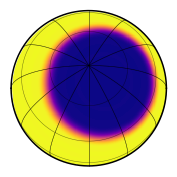

In [10]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.13214, radius=45, lat=72.95156, lon=45.33518)
map.inc = 17.04891
map.show()

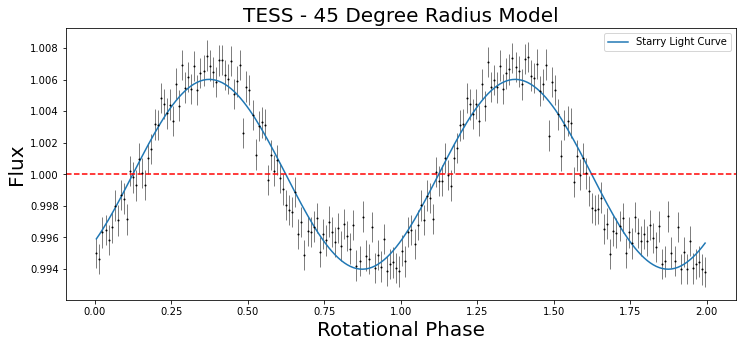

In [11]:
TESS_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('TESS - 45 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, TESS_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, TESS_flux, yerr=TESS_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [12]:
residuals = (TESS_flux - TESS_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.7347284263675644

# LT

In [13]:
# importing the data into arrays
# first column of the data file is phase data
LTPhaseHalf = np.loadtxt("GD356LT.dat", usecols=(0))
LTPhase = np.concatenate((LTPhaseHalf, LTPhaseHalf+1))
# second column of the data file is flux data
LTFluxHalf = np.loadtxt("GD356LT.dat", usecols=(1))
LTFlux = np.concatenate((LTFluxHalf+1, LTFluxHalf+1))
# third column of the data file is flux error
LTErrorHalf = np.loadtxt("GD356LT.dat", usecols=(2))
LTError = np.concatenate((LTErrorHalf, LTErrorHalf))

In [14]:
meanPhase, meanFlux, meanError = mean_data(LTPhase, LTFlux, LTError, 200)

LT_flux = meanFlux
LT_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

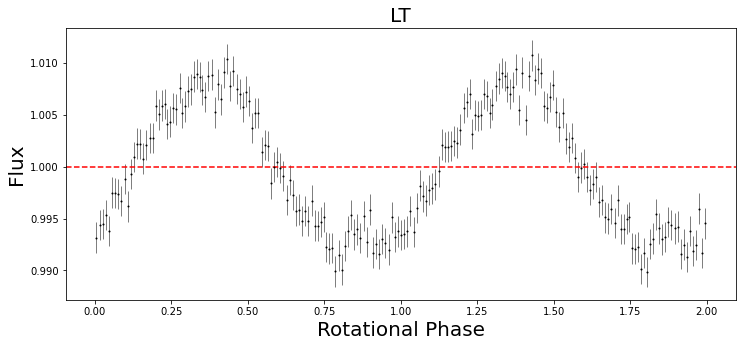

In [15]:
plt.figure(figsize=(12, 5))

plt.title('LT', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, LT_flux, yerr=LT_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [16]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.1)
    radius = 45
    lat = 72.95156
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 17.04891
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=LT_flux_err, observed=LT_flux)

In [17]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: 111.02733294466381 -> 1015.1791469466822


In [18]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.17475
lon          48.85479


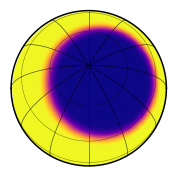

In [19]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.17475, radius=45, lat=72.95156, lon=48.85479)
map.inc = 17.04891
map.show()

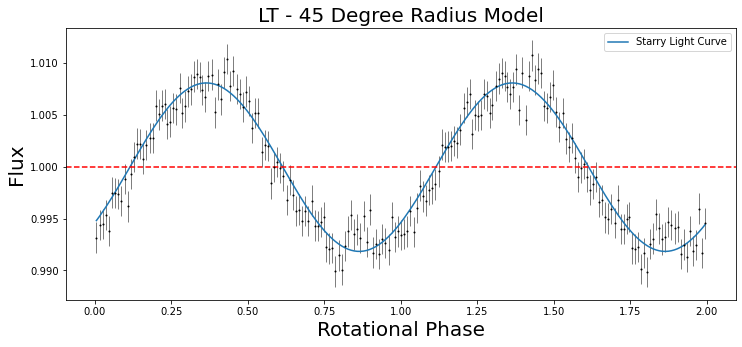

In [20]:
LT_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('LT - 45 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, LT_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, LT_flux, yerr=LT_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [21]:
residuals = (LT_flux - LT_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.0749120375101664

# PTO

In [22]:
# importing the data into arrays
# first column of the data file is phase data
PTO_PhaseHalf = np.loadtxt("GD356PTO.dat", usecols=(0))
PTO_Phase = np.concatenate((PTO_PhaseHalf, PTO_PhaseHalf+1))
# second column of the data file is flux data
PTO_FluxHalf = np.loadtxt("GD356PTO.dat", usecols=(1))
PTO_Flux = np.concatenate((PTO_FluxHalf+1, PTO_FluxHalf+1))
# third column of the data file is flux error
PTO_ErrorHalf = np.loadtxt("GD356PTO.dat", usecols=(2))
PTO_Error = np.concatenate((PTO_ErrorHalf, PTO_ErrorHalf))

In [23]:
meanPhase, meanFlux, meanError = mean_data(PTO_Phase, PTO_Flux, PTO_Error, 200)

PTO_flux = meanFlux
PTO_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

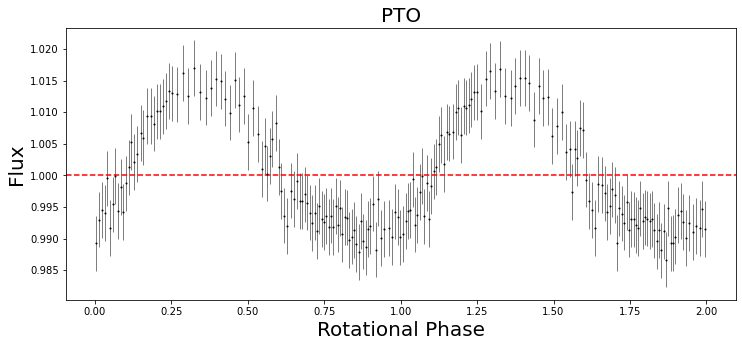

In [24]:
plt.figure(figsize=(12, 5))

plt.title('PTO', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, PTO_flux, yerr=PTO_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [25]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.1)
    radius = 45
    lat = 72.95156
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 17.04891
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=PTO_flux_err, observed=PTO_flux)

In [26]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: 614.1654128408844 -> 859.2158783558034


In [27]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.25003
lon          51.71745


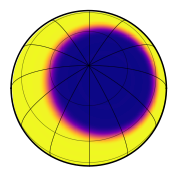

In [28]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.25003, radius=45, lat=72.95156, lon=51.71745)
map.inc = 17.04891
map.show()

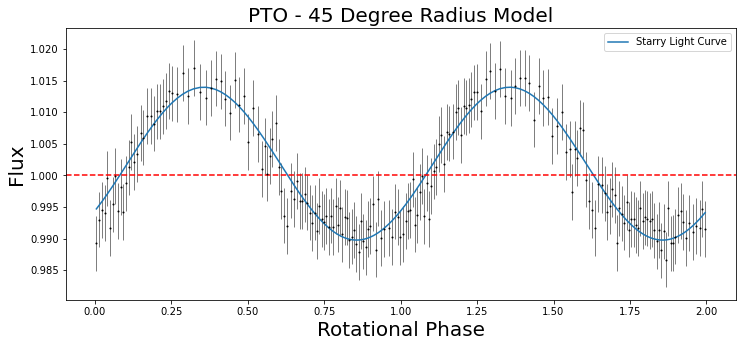

In [29]:
PTO_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('PTO - 45 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, PTO_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, PTO_flux, yerr=PTO_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [30]:
residuals = (PTO_flux - PTO_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

0.39708182645936163

# WHT

In [31]:
# importing the data into arrays
# first column of the data file is phase data
WHT_PhaseHalf = np.loadtxt("GD356WHT.dat", usecols=(0))
WHT_Phase = np.concatenate((WHT_PhaseHalf, WHT_PhaseHalf+1))
# second column of the data file is flux data
WHT_FluxHalf = np.loadtxt("GD356WHT.dat", usecols=(1))
WHT_Flux = np.concatenate((WHT_FluxHalf+1, WHT_FluxHalf+1))
# third column of the data file is flux error
WHT_ErrorHalf = np.loadtxt("GD356WHT.dat", usecols=(2))
WHT_Error = np.concatenate((WHT_ErrorHalf, WHT_ErrorHalf))

In [32]:
meanPhase, meanFlux, meanError = mean_data(WHT_Phase, WHT_Flux, WHT_Error, 200)

WHT_flux = meanFlux
WHT_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

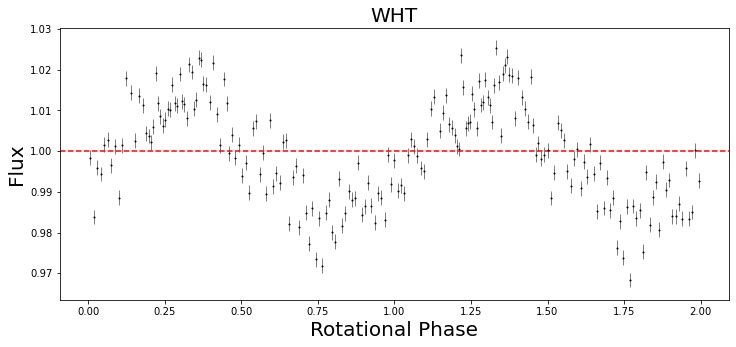

In [33]:
plt.figure(figsize=(12, 5))

plt.title('WHT', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, WHT_flux, yerr=WHT_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [34]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.1)
    radius = 45
    lat = 72.95156
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 17.04891
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=WHT_flux_err, observed=WHT_flux)

In [35]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -3073.3348053606214 -> -78.84370796798402


In [36]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.30033
lon          68.29700


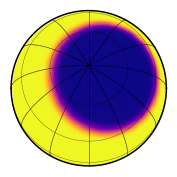

In [37]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.30033, radius=45, lat=72.95156, lon=68.29700)
map.inc = 17.04891
map.show()

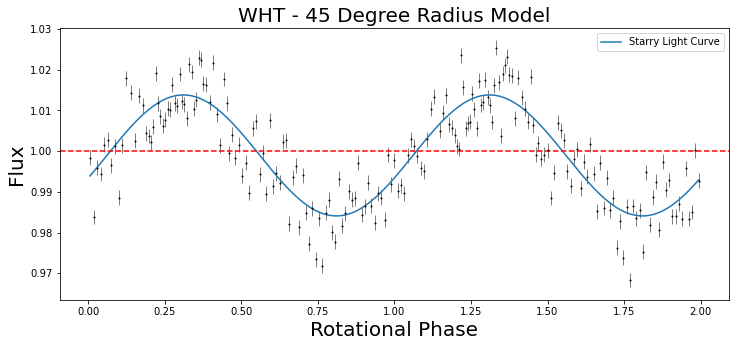

In [38]:
WHT_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('WHT - 45 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, WHT_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, WHT_flux, yerr=WHT_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [39]:
residuals = (WHT_flux - WHT_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

11.80435087662102

# ZTF-r

In [40]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356ZTFR.dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356ZTFR.dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

ZTFr_flux = meanFlux
ZTFr_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

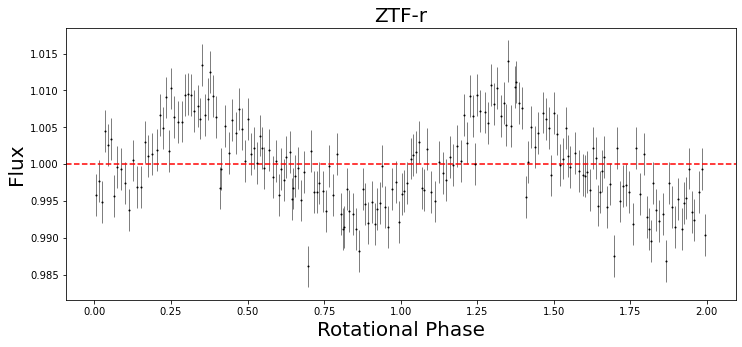

In [41]:
plt.figure(figsize=(12, 5))

plt.title('ZTF-r', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, ZTFr_flux, yerr=ZTFr_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [42]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 45
    lat = 72.95156
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 17.04891
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=ZTFr_flux_err, observed=ZTFr_flux)

In [43]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -33829.56295171993 -> 849.5532781666348


In [44]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.14115
lon          55.01395


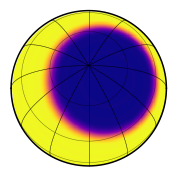

In [45]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.14115, radius=45, lat=72.95156, lon=55.01395)
map.inc = 17.04891
map.show()

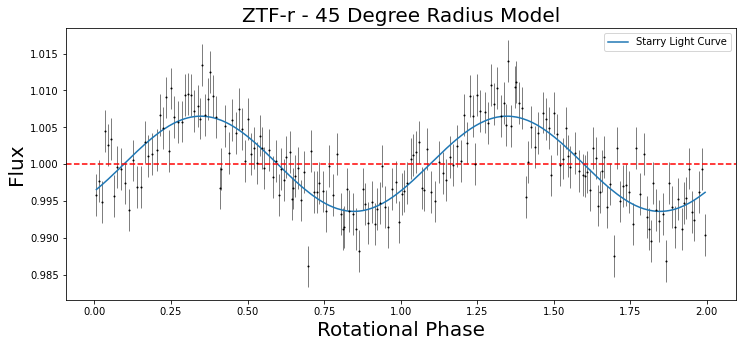

In [46]:
ZTFr_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('ZTF-r - 45 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, ZTFr_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, ZTFr_flux, yerr=ZTFr_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [47]:
residuals = (ZTFr_flux - ZTFr_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.3945923428609854

# ZTF-g

In [7]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356ZTFG.dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356ZTFG.dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

ZTFg_flux = meanFlux
ZTFg_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

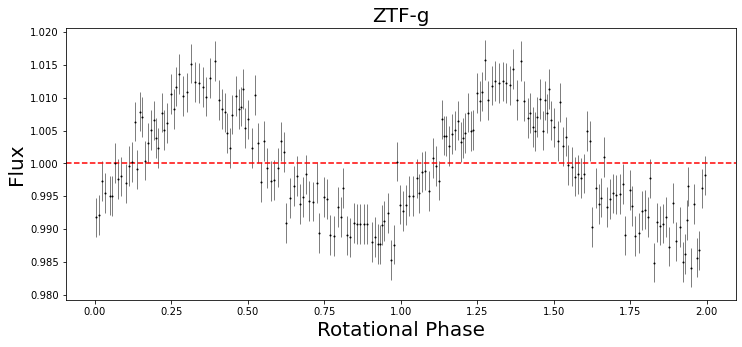

In [8]:
plt.figure(figsize=(12, 5))

plt.title('ZTF-g', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, ZTFg_flux, yerr=ZTFg_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [50]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 45
    lat = 72.95156
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 17.04891
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=ZTFg_flux_err, observed=ZTFg_flux)

In [51]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -29069.389964494818 -> 871.4398520016931


In [52]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.22194
lon          53.59630


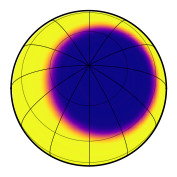

In [6]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.22194, radius=45, lat=72.95156, lon=53.59630)
map.inc = 17.04891
map.show()

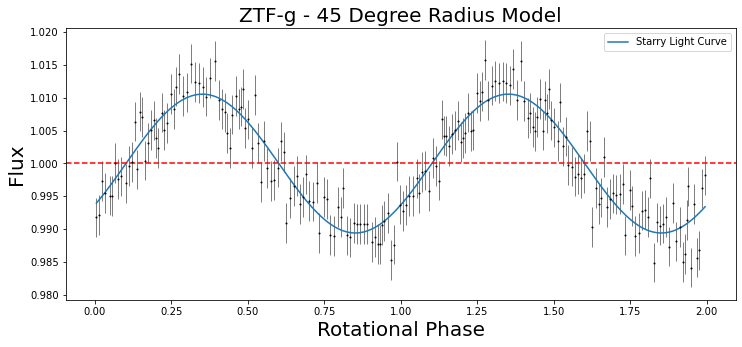

In [9]:
ZTFg_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('ZTF-g - 45 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, ZTFg_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, ZTFg_flux, yerr=ZTFg_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [10]:
residuals = (ZTFg_flux - ZTFg_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.043487195350433

# NUV

In [11]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTNUV.dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTNUV.dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

NUV_flux = meanFlux
NUV_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

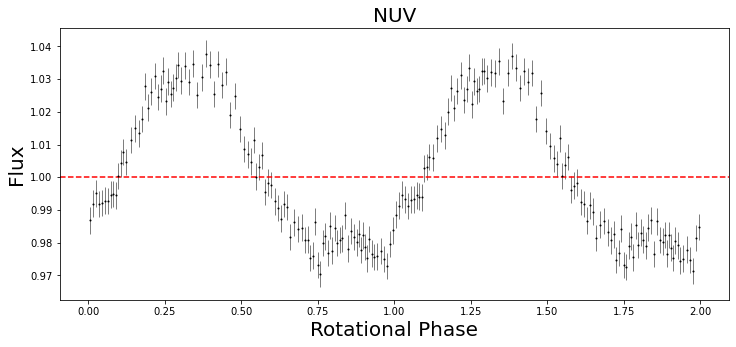

In [12]:
plt.figure(figsize=(12, 5))

plt.title('NUV', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV_flux, yerr=NUV_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [13]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 45
    lat = 72.95156
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 17.04891
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=NUV_flux_err, observed=NUV_flux)

In [14]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -13316.607133371062 -> 748.4711908882521


In [15]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.50257
lon          59.79948


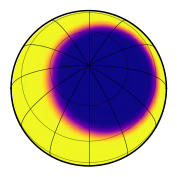

In [16]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.50257, radius=45, lat=72.95156, lon=59.79948)
map.inc = 17.04891
map.show()

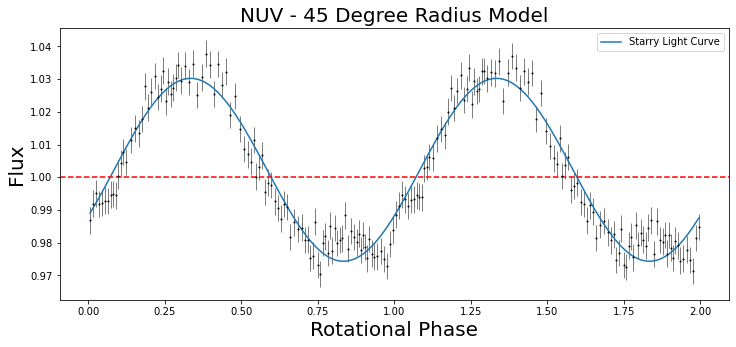

In [17]:
NUV_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('NUV - 45 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, NUV_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV_flux, yerr=NUV_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [18]:
residuals = (NUV_flux - NUV_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.7070200475671173

# NUV (2550 - 2950)

In [19]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTNUV(2550_2950).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTNUV(2550_2950).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

NUV3_flux = meanFlux
NUV3_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

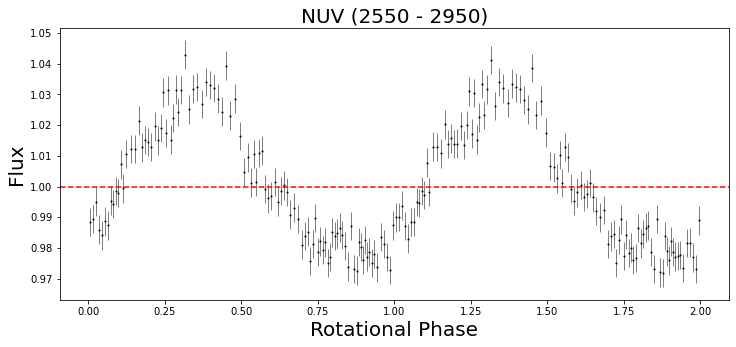

In [20]:
plt.figure(figsize=(12, 5))

plt.title('NUV (2550 - 2950)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV3_flux, yerr=NUV3_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [21]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 45
    lat = 72.95156
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 17.04891
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=NUV3_flux_err, observed=NUV3_flux)

In [22]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -9198.715627209844 -> 738.3545827487311


In [23]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.48039
lon          52.87511


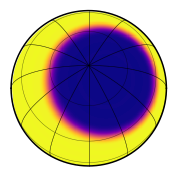

In [24]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.48039, radius=45, lat=72.95156, lon=52.87511)
map.inc = 17.04891
map.show()

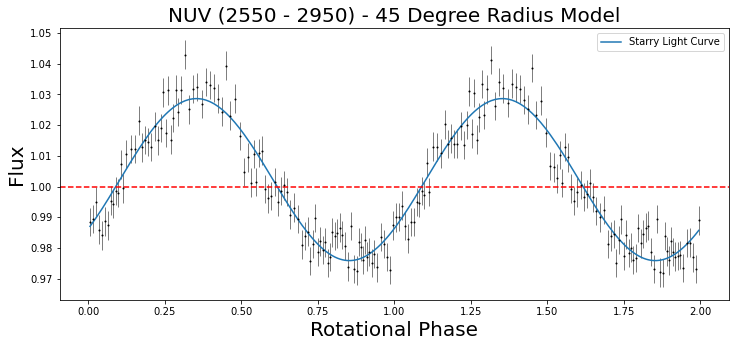

In [25]:
NUV3_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('NUV (2550 - 2950) - 45 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, NUV3_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV3_flux, yerr=NUV3_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [26]:
residuals = (NUV3_flux - NUV3_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.5397878781641163

# NUV (2150 - 2550)

In [27]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTNUV(2150_2550).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTNUV(2150_2550).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

NUV2_flux = meanFlux
NUV2_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

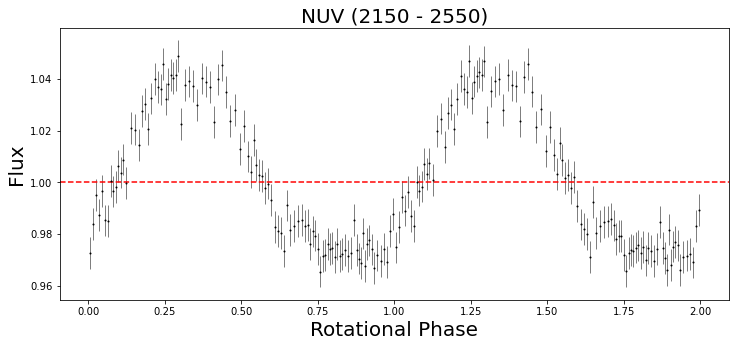

In [28]:
plt.figure(figsize=(12, 5))

plt.title('NUV (2150 - 2550)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV2_flux, yerr=NUV2_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [29]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 45
    lat = 72.95156
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 17.04891
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=NUV2_flux_err, observed=NUV2_flux)

In [30]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -5448.05308384471 -> 697.9049789426377


In [31]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.59492
lon          60.90219


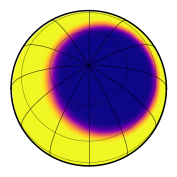

In [32]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.59492, radius=45, lat=72.95156, lon=60.90219)
map.inc = 17.04891
map.show()

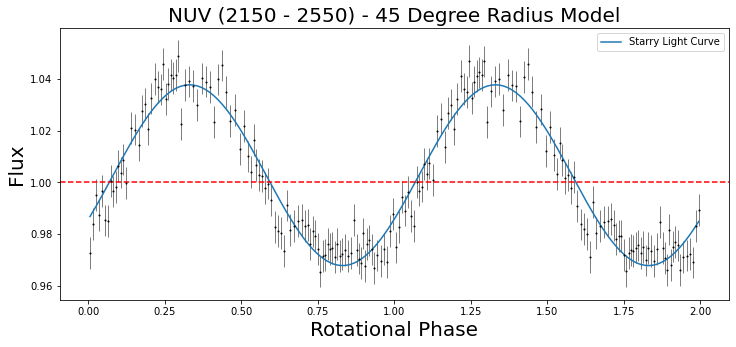

In [33]:
NUV2_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('NUV (2150 - 2550) - 45 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, NUV2_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV2_flux, yerr=NUV2_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [34]:
residuals = (NUV2_flux - NUV2_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.37451417015474

# NUV (1630 - 2150)

In [35]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTNUV(1630_2150).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTNUV(1630_2150).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

NUV1_flux = meanFlux
NUV1_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

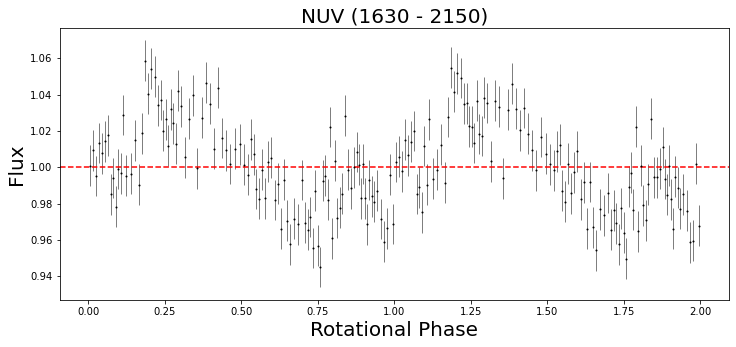

In [36]:
plt.figure(figsize=(12, 5))

plt.title('NUV (1630 - 2150)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV1_flux, yerr=NUV1_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [37]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.9999)
    radius = 45
    lat = 72.95156
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 17.04891
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=NUV1_flux_err, observed=NUV1_flux)

In [38]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -1823.9564360876864 -> 484.9973904095779


In [39]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.45628
lon          78.02306


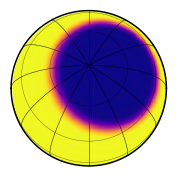

In [40]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.45628, radius=45, lat=72.95156, lon=78.02306)
map.inc = 17.04891
map.show()

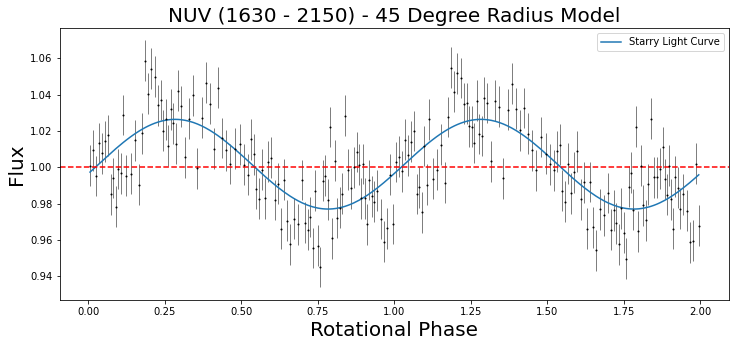

In [41]:
NUV1_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('NUV (1630 - 2150) - 45 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, NUV1_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV1_flux, yerr=NUV1_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [42]:
residuals = (NUV1_flux - NUV1_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

2.3172895458683036

# FUV

In [6]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTFUV.dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTFUV.dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

FUV_flux = meanFlux
FUV_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

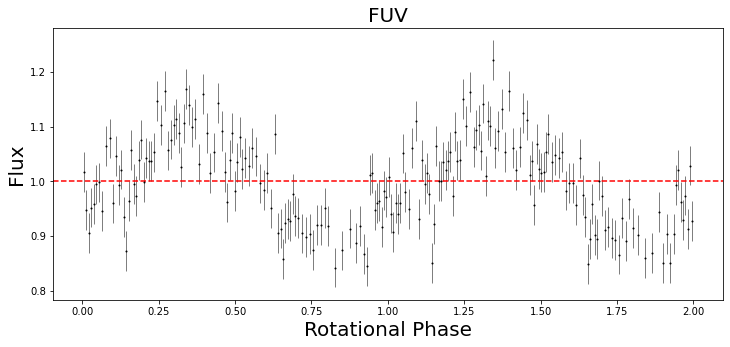

In [7]:
plt.figure(figsize=(12, 5))

plt.title('FUV', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV_flux, yerr=FUV_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [11]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=10, testval=0.9999)
    radius = 45
    lat = 72.95156
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 17.04891
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV_flux_err, observed=FUV_flux)

In [12]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: 17.742311519909045 -> 292.9568865975192


In [13]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      1.10052
lon          58.15226


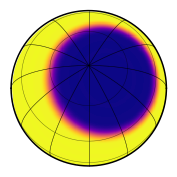

In [8]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=1, radius=45, lat=72.95156, lon=58.15170)
map.inc = 17.04891
map.show()

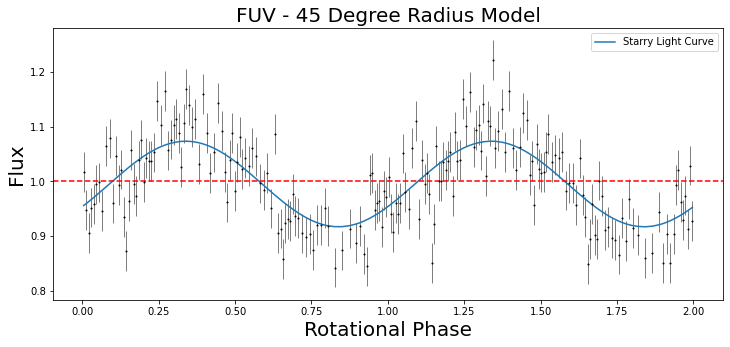

In [9]:
FUV_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV - 45 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, FUV_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV_flux, yerr=FUV_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [10]:
residuals = (FUV_flux - FUV_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.9583334433986206

# FUV (1520 - 1715)

In [14]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTFUV(1520_1715).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTFUV(1520_1715).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

FUV3_flux = meanFlux
FUV3_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

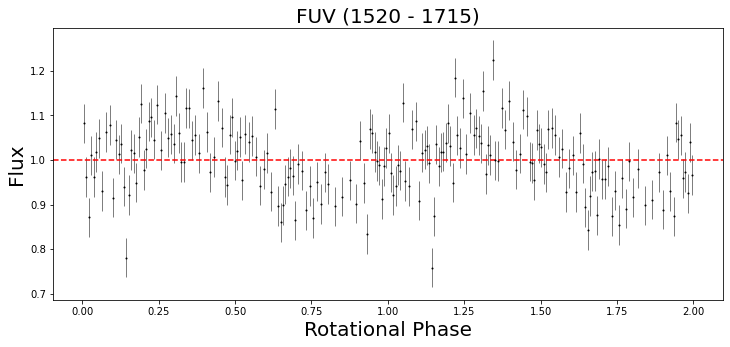

In [15]:
plt.figure(figsize=(12, 5))

plt.title('FUV (1520 - 1715)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV3_flux, yerr=FUV3_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [16]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=10, testval=0.9999)
    radius = 45
    lat = 72.95156
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 17.04891
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV3_flux_err, observed=FUV3_flux)

In [17]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: 65.7924843018108 -> 227.83262069442833


In [18]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.86520
lon          65.94092


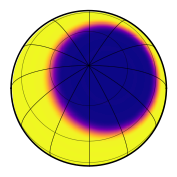

In [19]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.86520, radius=45, lat=72.95156, lon=65.94092)
map.inc = 17.04891
map.show()

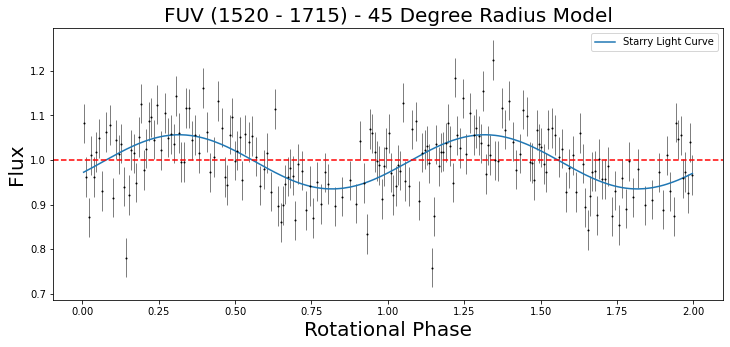

In [20]:
FUV3_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV (1520 - 1715) - 45 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, FUV3_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV3_flux, yerr=FUV3_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [21]:
residuals = (FUV3_flux - FUV3_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

2.1379250889176693

# FUV (1330 - 1520)

In [22]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTFUV(1330_1520).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTFUV(1330_1520).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

FUV2_flux = meanFlux
FUV2_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

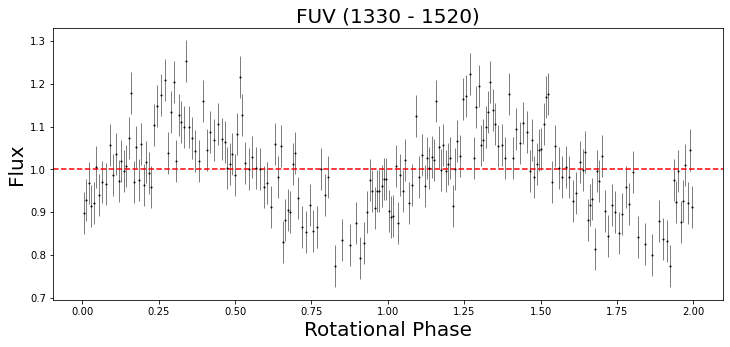

In [23]:
plt.figure(figsize=(12, 5))

plt.title('FUV (1330 - 1520)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV2_flux, yerr=FUV2_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [24]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=10, testval=0.9999)
    radius = 45
    lat = 72.95156
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 17.04891
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV2_flux_err, observed=FUV2_flux)

In [25]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: 78.01837264221857 -> 258.13167923879115


In [26]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      1.19274
lon          56.23396


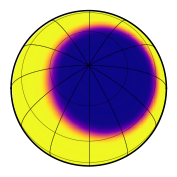

In [27]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=1, radius=45, lat=72.95156, lon=56.23396)
map.inc = 17.04891
map.show()

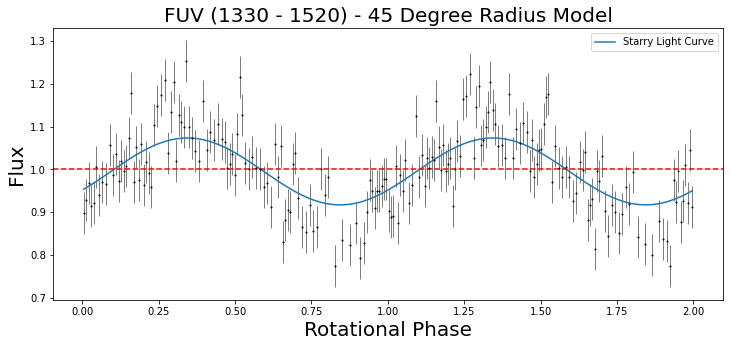

In [28]:
FUV2_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV (1330 - 1520) - 45 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, FUV2_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV2_flux, yerr=FUV2_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [29]:
residuals = (FUV2_flux - FUV2_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.8286695134719624

# FUV (1120 - 1330)

In [30]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTFUV(1120_1330).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTFUV(1120_1330).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

FUV1_flux = meanFlux
FUV1_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

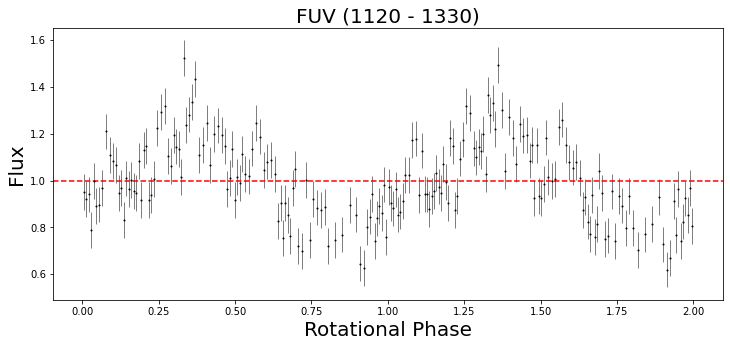

In [31]:
plt.figure(figsize=(12, 5))

plt.title('FUV (1120 - 1330)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV1_flux, yerr=FUV1_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [32]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=10, testval=0.9999)
    radius = 45
    lat = 72.95156
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 17.04891
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV1_flux_err, observed=FUV1_flux)

In [33]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -83.38813409794318 -> 113.45867770189089


In [34]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      1.48608
lon          50.75251


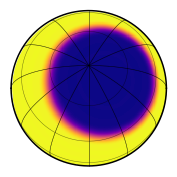

In [35]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=1, radius=45, lat=72.95156, lon=50.75251)
map.inc = 17.04891
map.show()

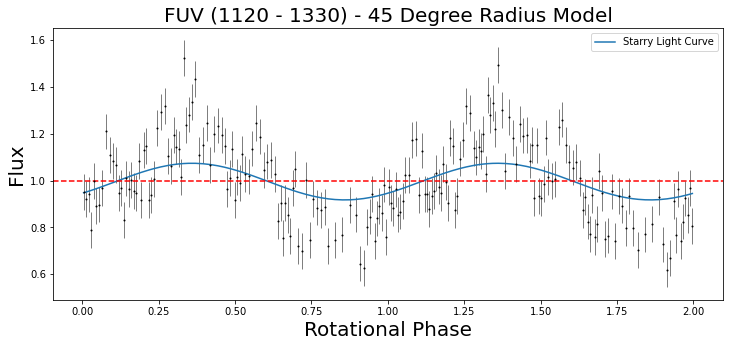

In [36]:
FUV1_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV (1120 - 1330) - 45 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, FUV1_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV1_flux, yerr=FUV1_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [37]:
residuals = (FUV1_flux - FUV1_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

3.2959736650671467